In [1]:
import numpy as np

# Charger le fichier
data = np.load("preds/S2_10000_full_output_test.npy", allow_pickle=True).item()

# Vérifier les clés
print("Clés disponibles :", list(data.keys()))

Clés disponibles : ['center_mask', 'saliency', 'heatmap', 'semantic', 'size', 'confidence', 'centerness', 'instance_masks', 'instance_boxes', 'pano_instance', 'pano_semantic', 'manual_semantic_argmax']


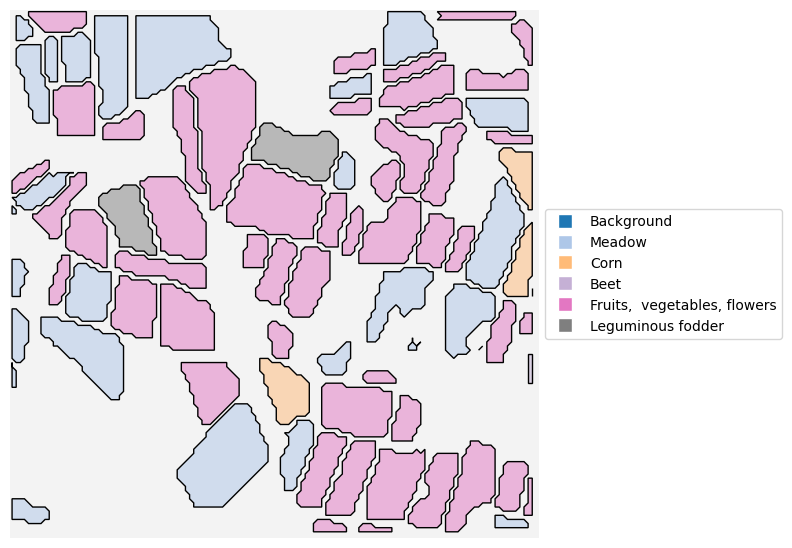

In [5]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
import numpy as np
import cv2 #opencv-python-headless

label_names = [
"Background",
"Meadow",
"Soft winter wheat",
"Corn",
"Winter barley",
"Winter rapeseed",
"Spring barley",
"Sunflower",
"Grapevine",
"Beet",
 "Winter triticale",
 "Winter durum wheat",
 "Fruits,  vegetables, flowers",
 "Potatoes",
 "Leguminous fodder",
 "Soybeans",
 "Orchard",
 "Mixed cereal",
 "Sorghum",
 "Void label"]

# Prédiction
pano_instances = data["pano_instance"][0]
semantic_logits = data["pano_semantic"][0]
pano_semantic_preds = np.argmax(semantic_logits, axis=0)

# Couleurs fixes par classe
cmap = mcolors.ListedColormap(cm.tab20(np.linspace(0, 1, len(label_names))))

# Image vide en fond
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(np.zeros_like(pano_instances), cmap='gray', alpha=0.05)

# Affichage des instances
for inst_id in np.unique(pano_instances):
    if inst_id == 0:
        continue
    mask = (pano_instances == inst_id)
    labels_in_mask = pano_semantic_preds[mask]
    if len(labels_in_mask) == 0:
        continue
    cl = np.bincount(labels_in_mask.flatten()).argmax()
    color = cmap(cl % len(label_names))

    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for co in contours:
        poly = patches.Polygon(co[:, 0, :], fill=True, alpha=0.5, linewidth=0, color=color)
        ax.add_patch(poly)
        poly = patches.Polygon(co[:, 0, :], fill=False, alpha=1, linewidth=1, color='black')
        ax.add_patch(poly)

# Légende : uniquement les classes présentes
unique_classes = np.unique(pano_semantic_preds)
legend_elements = [Line2D([0], [0], marker='s', color='w', label=label_names[i],
                          markerfacecolor=cmap(i), markersize=10)
                   for i in unique_classes if i < len(label_names)]
ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))

ax.axis('off')
plt.tight_layout()
plt.savefig("panoptic_prediction_wouf.png", bbox_inches='tight')
plt.show()

plt.show()


In [11]:
print(pano_semantic_preds.shape)

(20, 128, 128)


(1, 20, 128, 128)


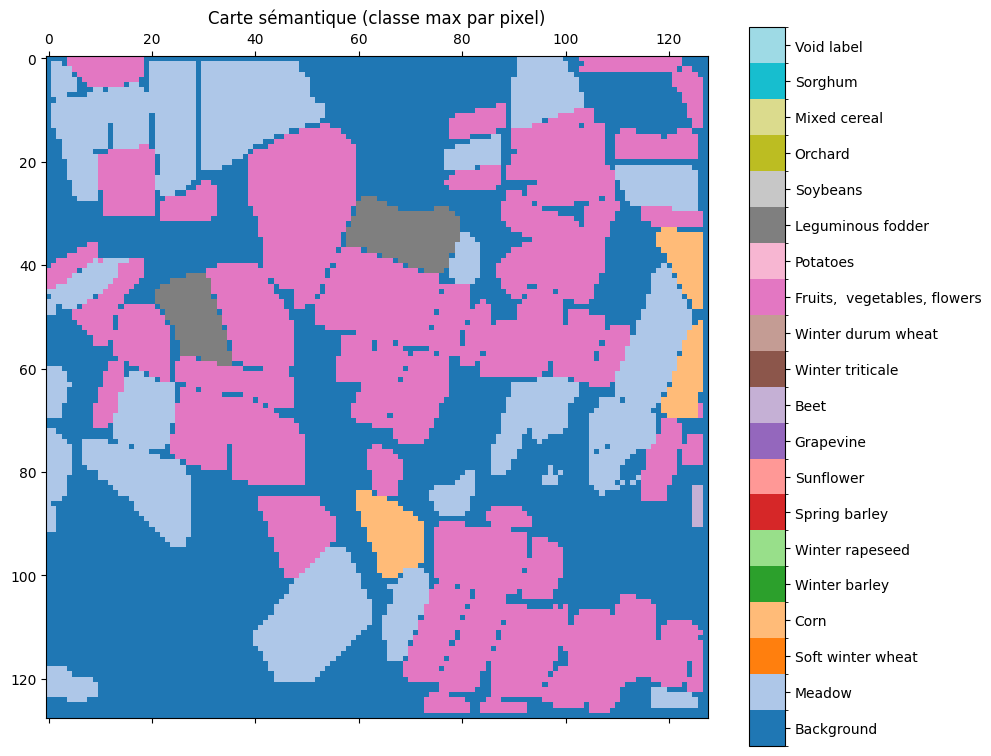

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

# Conversion si nécessaire
pano_semantic = data["pano_semantic"][0]
if hasattr(pano_semantic, "cpu"):
    pano_semantic = pano_semantic.cpu().numpy()

# pano_semantic.shape == (num_classes, H, W), exemple : (20, 256, 384)
semantic_map = np.argmax(pano_semantic, axis=0)  # -> (256, 384)
print(data["pano_semantic"].shape)  # Doit être (20, 256, 384)
# Liste de noms de classes (doit correspondre à num_classes)
class_names = [
"Background",
"Meadow",
"Soft winter wheat",
"Corn",
"Winter barley",
"Winter rapeseed",
"Spring barley",
"Sunflower",
"Grapevine",
"Beet",
 "Winter triticale",
 "Winter durum wheat",
 "Fruits,  vegetables, flowers",
 "Potatoes",
 "Leguminous fodder",
 "Soybeans",
 "Orchard",
 "Mixed cereal",
 "Sorghum",
 "Void label"]

# Colormap discrète
cmap = plt.get_cmap("tab20", len(class_names))
norm = BoundaryNorm(np.arange(len(class_names)+1)-0.5, len(class_names))

# Affichage
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.matshow(semantic_map, cmap=cmap, norm=norm)
cbar = plt.colorbar(im, ax=ax, ticks=np.arange(len(class_names)))
cbar.ax.set_yticklabels(class_names)
ax.set_title("Carte sémantique (classe max par pixel)")
plt.tight_layout()
plt.show()

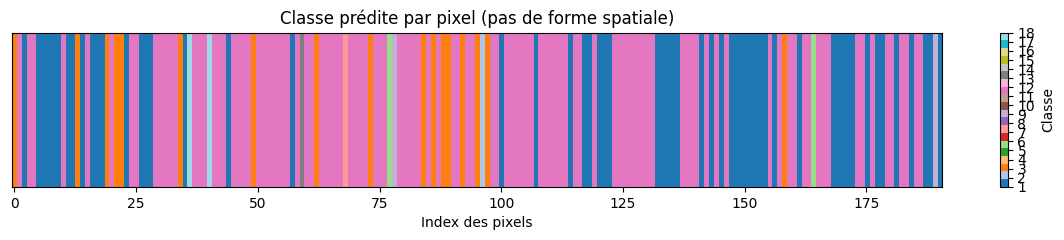

In [5]:
import numpy as np
import matplotlib.pyplot as plt

semantic_map = data["manual_semantic_argmax"]  # shape (N,)

plt.figure(figsize=(15, 2))
plt.imshow(semantic_map[np.newaxis, :], aspect="auto", cmap="tab20")
plt.yticks([])
plt.xlabel("Index des pixels")
plt.title("Classe prédite par pixel (pas de forme spatiale)")
plt.colorbar(ticks=np.arange(20), label="Classe")
plt.show()

Masque 0 - shape: (1, 1, 1)


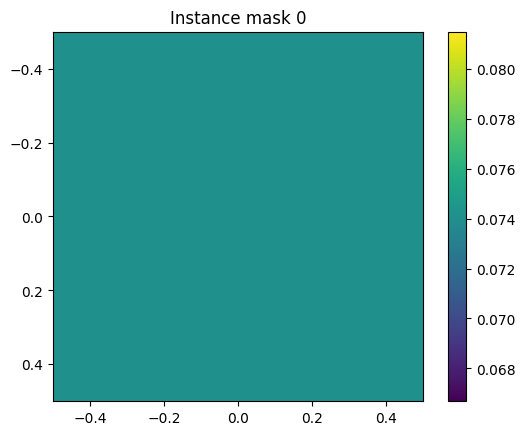

Masque 1 - shape: (1, 1, 1)


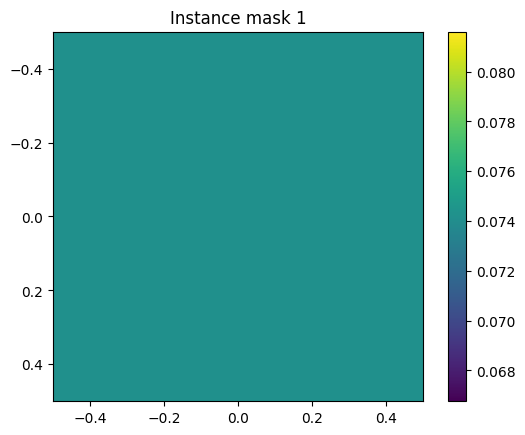

Masque 2 - shape: (1, 1, 1)


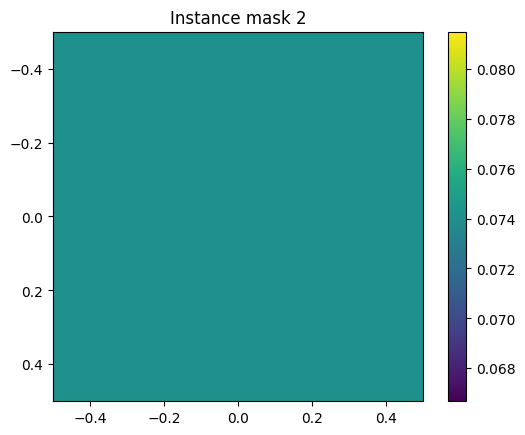

Masque 0 - shape: (1, 1, 1), dtype: float32, min: 0.07408852875232697, max: 0.07408852875232697
Masque 1 - shape: (1, 1, 1), dtype: float32, min: 0.0741816833615303, max: 0.0741816833615303
Masque 2 - shape: (1, 1, 1), dtype: float32, min: 0.07408437132835388, max: 0.07408437132835388


In [18]:
masks = data["instance_masks"]  # liste de tenseurs (sur GPU)

# Convertir tous les masques en CPU + NumPy
masks_cpu = [mask.cpu().numpy() for mask in masks]

# Afficher les 3 premiers masques
for i, mask in enumerate(masks_cpu[:3]):
    print(f"Masque {i} - shape: {mask.shape}")
    plt.figure()
    plt.title(f"Instance mask {i}")

    # Afficher une version 2D
    if mask.ndim == 3 and mask.shape[0] == 1:
        plt.imshow(mask[0])  # enlever la dimension singleton
    elif mask.ndim == 3:
        plt.imshow(mask[0])  # ou choisir le canal 0
    else:
        plt.imshow(mask)

    plt.colorbar()
    plt.show()
for i, mask in enumerate(masks_cpu[:3]):
    print(f"Masque {i} - shape: {mask.shape}, dtype: {mask.dtype}, min: {mask.min()}, max: {mask.max()}")

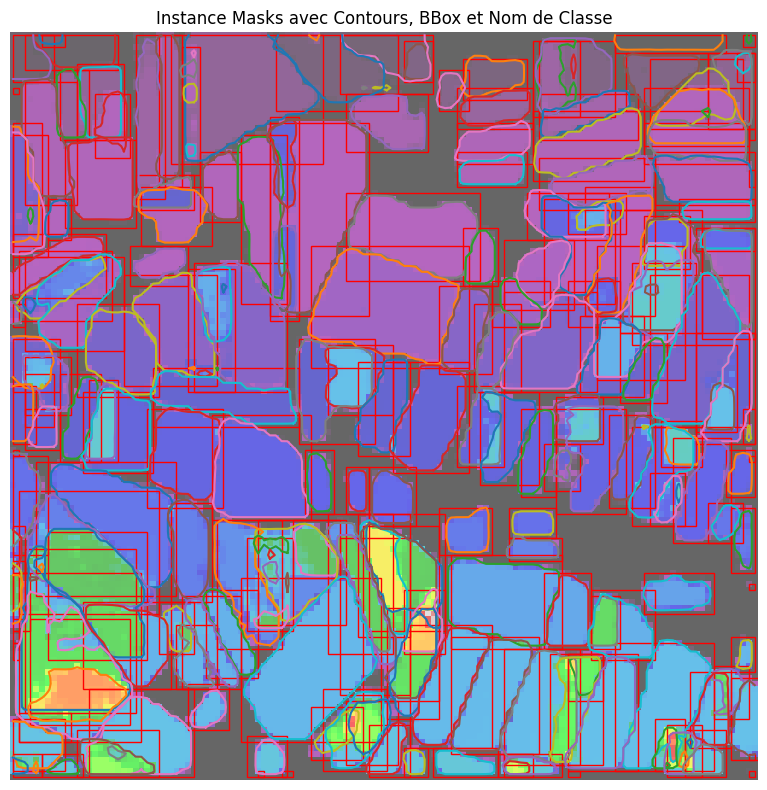

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure
import matplotlib.patches as patches
import torch

# Chargement des données
instance_masks = data["instance_masks"]
instance_boxes = data["instance_boxes"]
instance_classes = data["instance_classes"] if "instance_classes" in data else None

# Noms des classes (doit correspondre aux indices de instance_classes)
class_names = [
    "Background", "Meadow", "Soft winter wheat", "Corn", "Winter barley", "Winter rapeseed",
    "Spring barley", "Sunflower", "Grapevine", "Beet", "Winter triticale", "Winter durum wheat",
    "Fruits, vegetables, flowers", "Potatoes", "Leguminous fodder", "Soybeans", "Orchard",
    "Mixed cereal", "Sorghum", "Void label"
]

# Conversion éventuelle des masques
if isinstance(instance_masks, torch.Tensor):
    instance_masks = instance_masks.cpu().numpy()
if isinstance(instance_masks, list):
    instance_masks = [m.cpu().numpy() if isinstance(m, torch.Tensor) else m for m in instance_masks]

# Taille de l'image de référence
if "pano_semantic" in data:
    pano_shape = data["pano_semantic"].shape
    if len(pano_shape) == 4:
        image_shape = pano_shape[-2:]
    elif len(pano_shape) == 3:
        image_shape = pano_shape[-2:]
    elif len(pano_shape) == 2:
        image_shape = pano_shape
    else:
        raise ValueError("pano_semantic a une forme inattendue")
else:
    raise ValueError("Impossible de déduire la forme de l'image")

# Image vide pour visualisation
visualization = np.zeros(image_shape)

fig, ax = plt.subplots(figsize=(10, 8))

# Affichage des masques
for i, (mask, box) in enumerate(zip(instance_masks, instance_boxes)):
    if mask.ndim == 3 and mask.shape[0] == 1:
        mask = mask[0]
    elif mask.ndim != 2:
        print(f"⛔ Masque {i} ignoré : forme invalide {mask.shape}")
        continue

    x1, y1, x2, y2 = map(int, box)
    h, w = y2 - y1, x2 - x1

    if mask.shape != (h, w):
        print(f"⚠️ Masque {i} ignoré : shape={mask.shape} != attendu=({h}, {w})")
        continue

    mask_full = np.zeros(image_shape)
    mask_full[y1:y2, x1:x2] = mask

    contours = measure.find_contours(mask_full, 0.5)
    for contour in contours:
        ax.plot(contour[:, 1], contour[:, 0], linewidth=1.5)

    rect = patches.Rectangle((x1, y1), w, h, linewidth=1, edgecolor='red', facecolor='none')
    ax.add_patch(rect)

    # Texte avec nom de classe
    if instance_classes is not None:
        class_id = int(instance_classes[i])
        if class_id >= 0 and class_id < len(class_names):
            class_label = class_names[class_id]
            ax.text(x1, y1 - 5, class_label, color='white', fontsize=9,
                    bbox=dict(facecolor='black', alpha=0.6, edgecolor='none', pad=1.5))

    visualization += mask_full * (i + 1)

# Affichage final
ax.imshow(visualization, cmap='nipy_spectral', alpha=0.6)
ax.set_title("Instance Masks avec Contours, BBox et Nom de Classe")
plt.axis("off")
plt.tight_layout()
plt.show()



Shape des données: (1, 1, 128, 128)
[[[[2.3873036e-03 1.1015425e-03 1.5650976e-04 ... 1.4423836e-05
    2.6482853e-04 4.1971616e-06]
   [1.5701081e-04 6.3443376e-04 4.4200362e-05 ... 3.4528989e-06
    1.9429444e-05 1.0729709e-06]
   [3.1732663e-04 1.7494347e-03 4.4479422e-04 ... 1.2511709e-04
    1.4920528e-05 3.8463913e-06]
   ...
   [7.3821394e-04 4.4472341e-04 1.7599677e-04 ... 2.0291477e-04
    2.4493739e-03 3.8966746e-07]
   [9.3552648e-05 6.8459281e-05 5.2546839e-05 ... 2.9578278e-04
    3.5271365e-02 7.3164683e-06]
   [1.1112459e-05 2.6922608e-06 4.7506828e-06 ... 2.9923493e-07
    3.4476638e-05 8.7223645e-10]]]]
Valeurs min/max: 8.722364497337765e-10, 0.47876131534576416


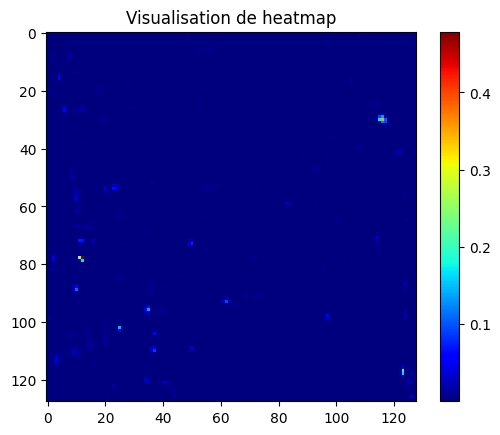

In [7]:
import numpy as np
import matplotlib.pyplot as plt


heatmap=data['heatmap']

# Afficher quelques informations sur le fichier
print(f"Shape des données: {heatmap.shape}")
print(heatmap)
print(f"Valeurs min/max: {heatmap.min()}, {heatmap.max()}")
    
    # Pour visualiser correctement, sélectionnez une image dans le batch et canal
image_to_display = heatmap[0, 0]  # Sélection du premier batch et canal

plt.imshow(image_to_display, cmap='jet', interpolation='nearest')
plt.title(f"Visualisation de heatmap")
plt.colorbar()  # Ajoute une barre de couleur pour comprendre la plage des valeurs
plt.show()



TypeError: Invalid shape (20, 256, 384) for image data

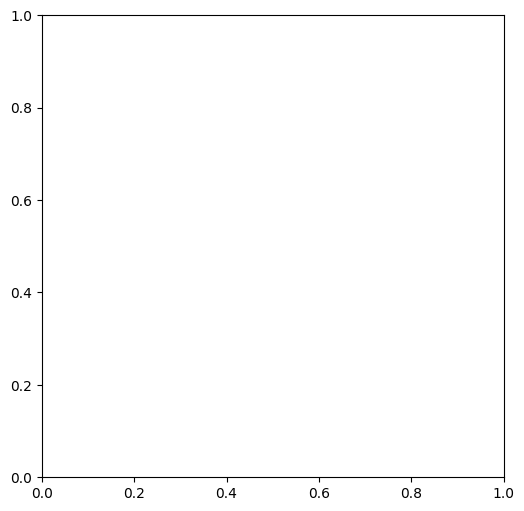

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors

def plot_semantic_map(pano_semantic):
    plt.figure(figsize=(8, 6))
    plt.imshow(pano_semantic, cmap="tab20", interpolation="none")
    plt.title("Carte sémantique (pano_semantic)")
    plt.colorbar()
    plt.axis("off")
    plt.show()

def plot_instance_map(pano_instance):
    plt.figure(figsize=(8, 6))
    plt.imshow(pano_instance, cmap="gist_ncar", interpolation="none")
    plt.title("Carte d’instances (pano_instance)")
    plt.colorbar()
    plt.axis("off")
    plt.show()

def plot_instance_masks(instance_masks, instance_boxes, image_shape):
    canvas = np.zeros(image_shape, dtype=np.uint8)
    plt.figure(figsize=(10, 10))
    ax = plt.gca()
    
    for idx, (mask, box) in enumerate(zip(instance_masks, instance_boxes)):
        if isinstance(mask, torch.Tensor):
            mask = mask.cpu().numpy()
        if mask.ndim == 3 and mask.shape[0] == 1:
            mask = mask[0]  # remove batch dim
        mask = (mask > 0.5).astype(np.uint8)
        y1, x1, y2, x2 = map(int, box)

        # Avoid shape mismatch
        mask_resized = np.zeros((y2 - y1, x2 - x1), dtype=np.uint8)
        mask_h, mask_w = mask.shape
        mask_resized[:mask_h, :mask_w] = mask

        canvas[y1:y2, x1:x2] += mask_resized * (idx + 1)

        # Contours
        contours = measure.find_contours(mask_resized, 0.5)
        for contour in contours:
            contour[:, 0] += y1
            contour[:, 1] += x1
            ax.plot(contour[:, 1], contour[:, 0], linewidth=1.5)

    ax.imshow(canvas, cmap="nipy_spectral")
    plt.title("Masques d’instance avec contours")
    plt.axis("off")
    plt.show()

def plot_heatmap(data, title):
    plt.figure(figsize=(8, 6))
    plt.imshow(data, cmap="inferno")
    plt.title(title)
    plt.colorbar()
    plt.axis("off")
    plt.show()

# Exemple d'utilisation :
output = np.load("preds/1_full_output.npy", allow_pickle=True).item()

plot_semantic_map(output["pano_semantic"][0])
plot_instance_map(output["pano_instance"][0])
plot_heatmap(output["confidence"][0], "Confidence")
plot_heatmap(output["centerness"][0], "Centerness")
plot_heatmap(output["size"][0], "Size")

image_shape = output["pano_semantic"][0].shape
plot_instance_masks(output["instance_masks"], output["instance_boxes"], image_shape)
